## 基于Python3实现自组织映射（Self-Organizing Map）神经网络算法

SOM神经网络有两层：第一层输入层，输入数据的层，是一维的，神经元的个数就是数据特征数；第二层是竞争层，也就是根据输入层输入的数据，神经元之间按照策略进行竞争的层，通常是二维的，行、列神经元个数可通过一些经验规则给定。其中竞争策略是通过下面的方式实现的：竞争层的每个神经元都有权重，当输入层输入某个样本时，就计算所有神经元的权重与该条样本的距离，然后通过规则调整距离比较小的神经元的权重，使得其更接近该样本。

**SOM算法就是将多条高维数据映射到二维的平面上，并且保证相近的数据在平面上的映射位置比较靠近，从而进行聚类。**

现有待聚类样本数据集$D$，维度为$(N, M)$，其中数据条数为$N$，每条数据的特征数为$M$。

### 一、SOM模型步骤：
 
 + （1）**竞争层神经元个数设置**：行神经元个数可以取 $\sqrt{5\sqrt{MN}}$(向上取整)，列神经元个数可以和行一样，或者多于行数的一半；
 + （2）**样本数据集归一化**：对每一列进行各自的归一化，例如可以将每一列缩放到$[0,1]$之间；
 + （3）**初始化神经元权重$W$**：每个神经元的权重均是长度为$M$的向量，每个元素均为随机选择的比较小的数，例如在0到0.01之间；
 
**开始训练SOM网络：迭代次数$s$，初始的学习率$u$，初始的邻域半径$r$：**
 
 + （4）**计算最佳匹配神经元(BMU)**：选择一条样本数据$X$，计算该数据与所有神经元权重之间的数据距离$m$，其中距离最小的神经元定义为为$BMU$；
 + （5）**获得邻域内的神经元**：根据当前的邻域半径$R(cs)$获取邻域中心为$BMU$的所有神经元，其中$R(cs)$是随着迭代次数的增加使得邻域半径逐渐衰减的函数，$cs$是当前的迭代次数；
 + （6）**更改样本权重**：对邻域中的每一个神经元，根据当前的学习率$U(cs)$以及该神经元与$BMU$之间的拓扑距离$d$，计算该神经元的学习率$L(U(cs),d)$。然后按照下式更新该神经元的权重：
 
 $$W = W + L(U(cs),d)*(X-W)$$
 
 其中$L(U(cs),d)$是关于当前的学习率和神经元之间的拓扑距离的函数，输出的是与$BMU$的拓扑距离为$d$的神经元的学习率，并且$d$越大，学习率越小；$U(cs)$是随着迭代次数的增加学习率逐渐衰减的函数；
 
 + （7）**训练完成**：所有样本数据运行完（4）-（6），$cs$加1，当其等于$s$或者误差基本不变时停止迭代；
 
 
注：神经元个数不宜少；数据距离$m$就是指的是神经元的M维权重与样本数据之间的距离，例如欧式距离，余弦距离；拓扑距离$d$指的是神经元网络中的神经元的几何位置之间的距离，例如曼哈顿距离，欧式距离；误差可以定义为所有样本数据与其$BMU$的最小数据距离的和；
 
### 二、SOM结果的可视化内容： 

 
 + 结果可视化
   + 神经元样式
       + 六边形

   + 可视化内容
       + 特征的值的分布(含有类别界限)
       + 类别的神经元激活程度
       + 样本标签的分布可视化      
        
### 三、Python3实现    

In [475]:
import numpy as np
import pandas as pd
from math import ceil, exp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib as mpl
import sys
from sklearn.cluster import KMeans
print('matplotlib版本', mpl.__version__)
print('numpy版本',np.__version__)
print('pandas版本',pd.__version__)
print('python版本', sys.version)

matplotlib版本 3.2.1
numpy版本 1.18.4
pandas版本 1.0.5
python版本 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:22:21) [MSC v.1916 64 bit (AMD64)]


In [476]:
# SOM可视化绘图的设置
config = {
    "font.family":'serif',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
    "font.size": 16,
    "axes.formatter.limits": [-2, 3]}
rcParams.update(config)
plt.rcParams['axes.unicode_minus']=False

In [496]:
# 示例数据集：鸢尾花
def get_som_data(filepath=r'C:\Users\GWT9\Desktop\Iris.xlsx'):
    data = pd.read_excel(filepath)
    # 数据打乱
    data = data.sample(frac=1)
    # 待聚类数据
    cluster_data = data.values[:,:-1]
    # 特征数据
    feature_data  = list(data.keys())[:-1]
    # 数据类别
    class_data = data.values[:, -1]
    
    return cluster_data, feature_data, class_data

som_data, ldata, stdata  = get_som_data()

In [497]:
# 训练SOM神经网络 
class AFSOM:
    def __init__(self, data):
        self.data = data  # 需要分类的数据，numpy数组格式（N,M）
        
        # 定义神经元的个数
        self.net_count = ceil((5 * (len(self.data)*len(self.data[0]))**0.5) **0.5)
        self.net_row = self.net_count  # 神经元的行数 
        self.net_column = int(0.7 * self.net_count) + 1 # 神经元的列数 
        
        # 算法训练,迭代次数
        self.epochs = 200
        
        # 距离函数
        self.disfunc = 'm'  # m：闵可夫斯基距离(默认为欧式距离) 
        
        # 学习率衰减函数
        self.learningrate_decay = 'e'  # e：指数衰减
        # 邻域半径衰减函数
        self.radius_decay = 'e'  # e：指数衰减
        # 邻域内学习率根据距离的衰减函数
        self.lr_r_decay = 'g' # g：高斯函数
                
        # 初始学习率
        self.learning_rate = 0.9
        # 初始的邻域半径
        self.radius = 5  
        # 每次迭代的学习率以及邻域半径的字典
        self.learning_rate_dict = self.decay_lr()
        self.radius_dict = self.decay_radius()
        
        # 神经元数据初始化
        self.net_data_dict = self.inital_net_data()        
        
        # 待聚类数据归一化
        self.data_normal, self.maxdata, self.mindata = self.column_norm_dataset()
        
        # 神经元的点的位置
        self.net_point_dict = self.get_point()
        
        # 存储误差
        self.error_list = []
        
       
    # 根据行、列的神经元的个数，定义二维平面上神经元的几何位置。也就是获得每个神经元的XY坐标.每个神经元最多有6个相邻的神经元，
    # 并且与相邻的欧式距离为1
    def get_point(self):
        # 字典形式
        point_dict = {}
        sign = 0
        for i in range(self.net_row):
            for j in range(self.net_column):
                if i % 2 == 0:
                    point_dict[sign] = np.array([j, i*(-(3**.5)/2)])
                else:
                    point_dict[sign] = np.array([j+(1/2), i*(-(3**.5)/2)])
                sign += 1
        return point_dict
        
    # 按列归一化的函数
    def column_norm_dataset(self):
        min_data = np.min(self.data, axis=0)
        max_data = np.max(self.data, axis=0)
        # 防止某些特征最大最小值相同，出现除数为0的情形
        return (self.data -  min_data +1e-28) / (max_data- min_data+1e-28), max_data, min_data
 
    # 初始化神经元数据
    def inital_net_data(self):
        # 为每一个神经元初始化数据
        init_net_data = {}
        for n in range(self.net_row * self.net_column):
            np.random.seed(n)
            random_data = np.random.random(len(self.data[0])) / 100 # 随机小数
            # 数据初始化
            init_net_data[n] = random_data
        return init_net_data    
        
    # 定义学习率的衰减函数：字典
    def decay_lr(self, decay_rate=0.9, step=25):  
        # 学习率字典
        lr_step_dict = {}
        # 迭代中每一次的学习率
        for i in range(self.epochs):
            if self.learningrate_decay == 'e':# 指数衰减
                lr = self.learning_rate * decay_rate ** (i / (self.epochs/ step))
            else: # 恒定学习率
                lr = 0.1
            lr_step_dict[i] = lr
        return lr_step_dict
        
    # 定义邻域半径衰减的函数：字典
    def decay_radius(self, decay_rate=0.9, step=18):
        # 邻域半径字典
        radius_step_dict = {}
        # 迭代中每一次的邻域半径
        for i in range(self.epochs):
            if self.radius_decay == 'e':# 指数衰减
                radius = self.radius * decay_rate ** (i / (self.epochs/ step))
            else:
                radius = 0
            radius_step_dict[i] = radius
        return radius_step_dict
        
    # 根据距离确定每个在邻域范围内的神经元的学习率
    def decay_lr_r(self, dis, epoch):
        if self.lr_r_decay == 'g':
            return self.learning_rate_dict[epoch] * exp(-(dis ** 2) / (2 * self.radius_dict[epoch] ** 2))

    # 反归一化神经元的数据
    def anti_norm(self, netdata, index):
        return netdata * (self.maxdata[index] - self.mindata[index]) + self.mindata[index]

    def minkowski_distance(self, datasample, datanet, p=2):
        edis = np.sum(np.power(datasample - datanet, p)) ** (1/p)   
        return edis
    
    def data_distance(self, datasample, datanet, p=2):
        if self.disfunc == 'm':
            return self.minkowski_distance(datasample, datanet, p)
    
    # 获取最佳匹配神经元邻域半径范围内的神经元
    def get_round(self, bmu_sign, epoch):
        # BMU神经元的位置
        cpoint_set = self.net_point_dict[bmu_sign]
        round_net = []
        for net in self.net_point_dict:
            # 计算欧氏距离
            dis = self.minkowski_distance(cpoint_set, self.net_point_dict[net], p=2)
            if dis <= self.radius_dict[epoch]:
                round_net.append(net)
        return round_net
    
    
    # 获取与某个神经元四周相邻的单元：拓扑结构相邻
    def adjoin_net(self, net):
        x, y = self.net_point_dict[net]
        point_set = [[x-1, y], [x+1, y], [x-1/2, y+(3**.5)/2], [x+1/2, y+(3**.5)/2], [x-1/2, y-(3**.5)/2], [x+1/2, y-(3**.5)/2]]
        net_set =[]
        for n in self.net_point_dict:
            for j in point_set:
                net_p = self.net_point_dict[n]
                if abs(j[0] -net_p[0]) < 1e-5 and abs(j[1] -net_p[1]) < 1e-5:
                    net_set.append(n)
        return net_set
    
           
    # 开始训练
    def som_train(self):
        # 当前迭代次数
        epoch = 0
        while epoch < self.epochs:
            # 误差 
            error = 0
            print('当前迭代次数', epoch)
            # 遍历数据
            for sdata in self.data_normal:
                # 计算BMU
                dis_dict = {}
                for nett in self.net_data_dict:
                    dis_dict[nett] = self.data_distance(sdata, self.net_data_dict[nett])
                # 选择最小距离对应的神经元
                min_net, min_dis  = sorted(dis_dict.items(), key=lambda s:s[1])[0]
                # 存储误差
                error += min_dis
                # 获取这个神经元的邻域
                neibourhood_nets = self.get_round(min_net, epoch)
                # 开始更改神经元的
                for nn in neibourhood_nets:
                    # 计算神经元图像中心点之间的距离:欧式距离
                    dis_net = self.minkowski_distance(self.net_point_dict[min_net], self.net_point_dict[nn], 2)
                    # 获得学习率
                    lr = self.decay_lr_r(dis_net, epoch)
                    # 更改权重
                    self.net_data_dict[nn] =np.add(self.net_data_dict[nn], lr * (sdata - self.net_data_dict[nn]))
            # 存储误差
            self.error_list.append(error)
            epoch += 1

        return print('SOM训练完毕')
    
    # 绘制学习率、邻域半径、以及训练误差的曲线
    def plot_train(self):
        # 获取数据:迭代次数
        epoch_list = range(self.epochs)
        # 学习率
        lr_list = [self.learning_rate_dict[k] for k in epoch_list]
        # 邻域半径
        r_list = [self.radius_dict[k] for k in epoch_list]
        
        # 利用共同的坐标轴
        plt.figure(figsize=(10, 5))
        host = host_subplot(111, axes_class=axisartist.Axes)
        plt.subplots_adjust(right=0.75)

        par1 = host.twinx()
        par2 = host.twinx()

        par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

        par1.axis["right"].toggle(all=True)
        par2.axis["right"].toggle(all=True)

        p1, = host.plot(epoch_list, lr_list, label="学习率")
        p2, = par1.plot(epoch_list, r_list, label="邻域半径")
        p3, = par2.plot(epoch_list, self.error_list, label="误差")

        host.set_xlabel("迭代次数")
        host.set_ylabel("学习率")
        par1.set_ylabel("邻域半径")
        par2.set_ylabel("误差")

        host.legend()

        host.axis["left"].label.set_color(p1.get_color())
        par1.axis["right"].label.set_color(p2.get_color())
        par2.axis["right"].label.set_color(p3.get_color())

        plt.show()

In [498]:
# 鸢尾花的示例
som_iris = AFSOM(som_data)

In [499]:
# SOM算法运行
som_iris.som_train()

当前迭代次数 0
当前迭代次数 1
当前迭代次数 2
当前迭代次数 3
当前迭代次数 4
当前迭代次数 5
当前迭代次数 6
当前迭代次数 7
当前迭代次数 8
当前迭代次数 9
当前迭代次数 10
当前迭代次数 11
当前迭代次数 12
当前迭代次数 13
当前迭代次数 14
当前迭代次数 15
当前迭代次数 16
当前迭代次数 17
当前迭代次数 18
当前迭代次数 19
当前迭代次数 20
当前迭代次数 21
当前迭代次数 22
当前迭代次数 23
当前迭代次数 24
当前迭代次数 25
当前迭代次数 26
当前迭代次数 27
当前迭代次数 28
当前迭代次数 29
当前迭代次数 30
当前迭代次数 31
当前迭代次数 32
当前迭代次数 33
当前迭代次数 34
当前迭代次数 35
当前迭代次数 36
当前迭代次数 37
当前迭代次数 38
当前迭代次数 39
当前迭代次数 40
当前迭代次数 41
当前迭代次数 42
当前迭代次数 43
当前迭代次数 44
当前迭代次数 45
当前迭代次数 46
当前迭代次数 47
当前迭代次数 48
当前迭代次数 49
当前迭代次数 50
当前迭代次数 51
当前迭代次数 52
当前迭代次数 53
当前迭代次数 54
当前迭代次数 55
当前迭代次数 56
当前迭代次数 57
当前迭代次数 58
当前迭代次数 59
当前迭代次数 60
当前迭代次数 61
当前迭代次数 62
当前迭代次数 63
当前迭代次数 64
当前迭代次数 65
当前迭代次数 66
当前迭代次数 67
当前迭代次数 68
当前迭代次数 69
当前迭代次数 70
当前迭代次数 71
当前迭代次数 72
当前迭代次数 73
当前迭代次数 74
当前迭代次数 75
当前迭代次数 76
当前迭代次数 77
当前迭代次数 78
当前迭代次数 79
当前迭代次数 80
当前迭代次数 81
当前迭代次数 82
当前迭代次数 83
当前迭代次数 84
当前迭代次数 85
当前迭代次数 86
当前迭代次数 87
当前迭代次数 88
当前迭代次数 89
当前迭代次数 90
当前迭代次数 91
当前迭代次数 92
当前迭代次数 93
当前迭代次数 94
当前迭代次数 95
当前迭代次数 96
当前迭代次数 97
当前迭代次数 98
当前迭代次数 99
当前迭代次数 100

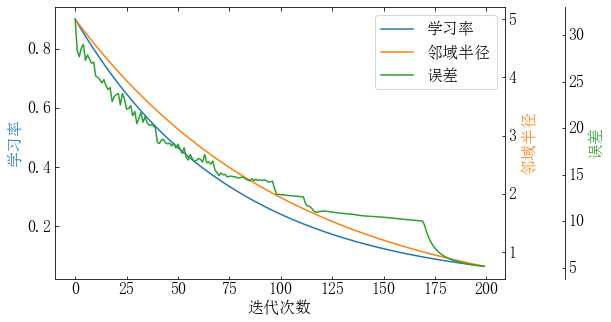

In [500]:
# 输出训练过程
som_iris.plot_train()

In [501]:
# 第二部分： 图形
class VISOM(AFSOM):
    def __init__(self, data, net_data_dict, stationlist, datalabel=None,  cluster=False):
        super(VISOM, self).__init__(data)
        
        # 训练后的样本的权重
        self.net_data_weight = net_data_dict
        self.slist = stationlist # 每条数据的标签，列表格式，长度为Ｎ 不为空
        
        self.label=datalabel  # 每条数据中每个特征的标签，列表格式，长度为M，可为空

        
        # stationlist不为None, cluster=True。说明每条数据知道类别，用该方法进行验证类别。否则的话，需要自定义类别数、
        self.c_sign = cluster
        # 数据类别个数
        self.cc = 3
        self.define_cc()
        
        # 可视化设置
        # 高宽比为2比根号3，为正六边形
        self.height = 8   
        self.width = 4*(3**0.5)
        self.tap = 0 # 控制图形之间的间隔 
            
        # 颜色映射 
        # 定义colorbar的颜色帧,线性补帧，自定义colormap的名字
        my_cmap = LinearSegmentedColormap.from_list('SOM', ['#3D26A8', '#3AC893', '#F9FA15'])
        self.color_config = my_cmap  # 或者官方设定plt.get_cmap('viridis))
        
        # 输出的图片大小
        self.figsize=(8, 7)        

        # 图形点的字典:输出每个指标的特征图谱的图形：六边形
        self.point_dict = self.get_hexagon()
        
        # 图形点字典：输出神经元之间距离的图形
        self.point_dict_distance, self.net_line_dict = self.transpose_point()
        
        self.border = None
        # 被击中的
        self.data_hinted_dict, self.data_hinted_data, self.hhnet_list = self.get_hinted_net()
        
    # 定义数据类别个数
    def define_cc(self):
        if self.slist is not None:
            if self.c_sign:
                self.cc = len(set(self.slist))
 
    # 神经元的图形为：六边形
    def get_hexagon(self): 
        # 初始的点
        a=b=A=B=0
        # 存储每个神经元的点的字典
        net_point_dict = {}
        # 网络的行
        row_sign = 0
        # 神经元编号
        net_sign = 0
        while row_sign < self.net_row:
            # 网络的列
            column_sign = 0
            while column_sign < self.net_column:
                # 逆时针的六个点
                one = [a, b+self.height/2]
                two = [a-self.width/2, b+(self.height/2-self.width/(2 * 3** 0.5))]
                three = [a - self.width/2, b-(self.height/2- self.width/(2 * 3** 0.5))]
                four = [a, b-self.height/2]
                five = [a + self.width/2, b-(self.height/2-self.width/(2 * 3** 0.5))]
                six = [a + self.width/2, b+(self.height/2-self.width/(2 * 3** 0.5))]
                # 横纵坐标分开
                x_number = [one[0], two[0], three[0], four[0], five[0], six[0], one[0]]
                y_number = [one[1], two[1], three[1], four[1], five[1], six[1], one[1]]
                # 存储
                net_point_dict[net_sign] = [np.array([a, b]), [x_number, y_number]]
                net_sign +=1
                column_sign += 1
                # 更新a，b
                a = a+ self.width
                b = b
            row_sign += 1
            if row_sign % 2 == 1:
                a = A + self.width/2 
                b = B - self.height + self.width/ (2 * 3** 0.5)
                C = a
                D = b
            else:
                a = C - self.width/2 
                b = D - self.height + self.width/(2 * 3** 0.5)
                A = a
                B = b
        return net_point_dict   
    

    # 生成单元格之间的距离图像，
    def transpose_point(self, m=0.3):
        # 第一部分：图形按比例缩小
        # 第二部分：图像之间添加多边形连线
        point_net_dict = {}
        # 两个单元之间的连线
        add_nets = {}
        # 存储
        for k in self.point_dict:
            # 该神经元的中心点
            kx, ky = self.point_dict[k][0]
            # 等比例缩小
            listx, listy = self.point_dict[k][1]
            # 缩小后的点
            small_x, small_y = [], []
            for x, y in zip(listx, listy):
                small_x.append(m*x +(1-m) * kx)
                small_y.append(m*y +(1-m) * ky)
            # 存储中心点、图形的点    
            point_net_dict[k] = [[kx, ky], [small_x, small_y]]
            # 获取四周的单元格
            round_net = self.adjoin_net(k)
            # 图形之间的多边形的连线
            for rnet in round_net:
                cxx, cyy = self.point_dict[rnet][0]
                # 首先获取两个相邻神经单元的2个交点
                list_X, list_Y = self.point_dict[rnet][1]
                add_point_x = []
                add_point_y = []
                for a, b in zip(listx[:-1], listy[:-1]):
                    for c, d in zip(list_X[:-1], list_Y[:-1]):
                        if abs(a-c) < 1e-8 and abs(b-d) < 1e-8:
                            add_point_x.append(a)
                            add_point_y.append(b)
        
                # 然后得到这2个点各自缩小后的点
                mul_x = []
                mul_y = []
                for xx, yy in zip(add_point_x, add_point_y):
                    # 计算单元缩小后的点
                    k_xx = m*xx +(1-m) * kx
                    k_yy = m*yy +(1-m) * ky
                    
                    rnet_xx = m*xx +(1-m) * cxx
                    rnet_yy = m*yy +(1-m) * cyy
                    
                    
                    mul_x += [k_xx, xx, rnet_xx]
                    mul_y += [k_yy, yy, rnet_yy]
                
                new_mu_x = mul_x[:3] + mul_x[3:][::-1] + [mul_x[0]]
                new_mu_y = mul_y[:3] + mul_y[3:][::-1] + [mul_y[0]]

                # 中心点的连线,设置较短
                # 图形之间的连接点在边上，要相应的缩小
                add_x  = (kx + cxx) / 2
                add_y = (ky + cyy) / 2
                                       
                p1_x, p1_y = (1-m)*add_x + m*kx, (1-m)*add_y + m*ky
                p2_x, p2_y =  (1-m)* add_x + m*cxx, (1-m)* add_y + m*cyy
                    
                add_nets['%s_%s'%(rnet, k)] = [[p1_x, p2_x], [p1_y, p2_y], [new_mu_x, new_mu_y]]
                    
        return point_net_dict, add_nets
    
                        
        
    # 第三部分： 可视化结果
    
    # 获取被击中的神经元序列：神经元：击中的数据样本对应的名称。神经元，击中的样本数据
    def get_hinted_net(self):
        # 被击中的神经元
        hited_nets_list = []
        hinted_nets_dict = {}
        hinted_nets_data = {}
        for danor, sanor in zip(self.data_normal, self.slist):
            nets_dict = {}
            for nor in self.net_data_weight:
                diss = self.data_distance(self.net_data_weight[nor], danor)
                nets_dict[nor] = diss
            # 计算最小值
            min_nn = sorted(nets_dict.items(), key=lambda s:s[1])[0][0]
            if min_nn in hinted_nets_dict:
                hinted_nets_dict[min_nn].append(sanor)
                hinted_nets_data[min_nn].append(danor)
            else:
                hinted_nets_dict[min_nn] = [sanor]
                hinted_nets_data[min_nn] = [danor]
            if min_nn not in hited_nets_list:
                hited_nets_list.append(min_nn)
                
        return hinted_nets_dict, hinted_nets_data, hited_nets_list
   

            
    # 根据单元格子的数值，单元格子编号，图片名称，图例名称，每个神经元文字
    def plot_net_data(self, netdata, netlist, title, label, tap, net_text=None):
        # 将数据转化到0到1
        ndata = (netdata - min(netdata)) / (max(netdata) - min(netdata))
        # 对应的颜色
        color_map = self.color_config(ndata)[:, :-1]
        # 新建图片
        plt.figure(figsize=self.figsize)   
        plt.axis('equal')
        plt.axis('off')

        # 开始绘制
        for ni, nv in enumerate(netlist):
            x, y = self.point_dict[nv][1]
            cx, cy = self.point_dict[nv][0]
            plt.plot(x, y, lw=tap,color='gray')
            plt.fill(x, y,color=color_map[ni])
            # 添加单元标签
            if net_text:
                plt.text(cx, cy, net_text[ni], horizontalalignment='center',verticalalignment='center')

        plt.text((self.net_column-1) * self.width/2 , self.height/2+4, title, horizontalalignment='center',verticalalignment='center')
        
        # 添加类别界限
        if self.border is not None:
            title = 'border%s' % title
            for kkk in self.border:
                for xyuu in self.border[kkk]:
                    ux, uy = xyuu
                    plt.plot(ux, uy, color='tab:red', lw=3)

        # 添加colorbar
        norm = mpl.colors.Normalize(vmin=min(netdata), vmax=max(netdata))
        #　图例的标签
        ticks = np.linspace(min(netdata), max(netdata), 3)
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=self.color_config),
                     shrink=0.5*(self.height/self.width), label=label, ticks=ticks, orientation='vertical',aspect=30)
        plt.tight_layout()
        plt.savefig('data/%s_SOM.png' % title, dpi=100, bbox_inches = 'tight')
        plt.close()
                         
    # 绘制每个监测指标的特征图谱
    def plot_sigle(self):
        if self.label is None:
            self.label = ['feature%s' % d for d in range(len(self.data[0]))]
        # 记录每个单元格的每个特征的数据
        for index, value in enumerate(self.label):
            # 特征数据
            net_feature = []
            # 神经元编号
            net_sign = []
            # 遍历神经元
            for nn in self.net_data_weight:
                # 反归一化
                f_data = self.net_data_weight[nn][index] * (self.maxdata[index] - self.mindata[index]) +self.mindata[index]
                net_feature.append(f_data)
                net_sign.append(nn)
            # 绘图
            self.plot_net_data(np.array(net_feature), net_sign, value, '浓度', self.tap)
        
        return print('每个特征的图谱绘制完毕')

    
    # 计算每个神经元与其相邻的神经元各个边的颜色
    def plot_class_distance(self):
        # 遍历神经元的权重字典
        plt.figure(figsize=self.figsize)
        plt.axis('equal')
        plt.axis('off')
        # 根据距离的值输出不同的颜色:首先要获取距离数值的序列
        dis_net_dict = {}
        for net in self.net_data_weight:
            round_net = self.adjoin_net(net)
            for rnet in round_net:
                dis = self.data_distance(self.net_data_weight[net], self.net_data_weight[rnet])
                dis_net_dict['%s_%s'%(net, rnet)] = dis
        # 距离的列表
        dis_lsit = np.array(list(set(dis_net_dict.values())))
        
        # 映射颜色
        # 将数据转化到0到1
        ndata = (dis_lsit - min(dis_lsit)) / (max(dis_lsit) - min(dis_lsit))
        # 对应的颜色
        color_map = plt.get_cmap('YlOrRd')(ndata)[:, :-1]

        # 然后根据不同的数值绘制不同的颜色
        for kf in self.net_line_dict:
            x, y, z= self.net_line_dict[kf]
            # 绘制多边形
            plt.fill(z[0], z[1], color=color_map[list(dis_lsit).index(dis_net_dict[kf])])
            # 绘制边
            plt.plot(x, y, color='r', lw=1) 
        # 添加colorbar
        norm = mpl.colors.Normalize(vmin=min(dis_lsit), vmax=max(dis_lsit))
        #　图例的标签
        ticks = np.linspace(min(dis_lsit), max(dis_lsit), 3)
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('YlOrRd')),
                     shrink=0.5*(self.height/self.width), label='距离', ticks=ticks, orientation='vertical',aspect=30)
        for k in self.point_dict_distance:
            point_set_x, point_set_y = self.point_dict_distance[k][1]
            plt.plot(point_set_x, point_set_y, lw=3, c='#666699')
            # 击中与没有击中的颜色不同
            if k in self.hhnet_list:
                plt.fill(point_set_x, point_set_y, c='#666699')
            else:
                plt.fill(point_set_x, point_set_y, c='w')
            
        plt.tight_layout()
        plt.savefig('data/bian_class.png', dpi=100, bbox_inches = 'tight')
        plt.close()
        
        
    # 绘制击中神经元的次数
    def plot_out_hits(self):
        plt.figure(figsize=(10, 10))
        plt.axis('equal')
        plt.axis('off')
        # 存数每个单元被击中的次数
        net_hits_dict = {net:len(self.data_hinted_dict[net]) for net in self.data_hinted_dict}

        # 开始绘制，图形的大小按照比例进行缩放
        # 首先获取值的列表
        hits_list = sorted(list(set(net_hits_dict.values())))
        # 在0.5到1之间
        shape_out = list(np.linspace(0.5, 1, len(hits_list)))
        # 获得图形的点
        tuxing_dict = {}
        # 计算缩放坐标的函数
        for k in self.point_dict:
            # 该神经元的中心点
            kx, ky = self.point_dict[k][0]
            # 等比例缩小
            listx, listy = self.point_dict[k][1]
            # 缩小后的点
            small_x, small_y = [], []
            if k in net_hits_dict:
                hits_n = net_hits_dict[k]
                # 缩放的比例
                p = shape_out[hits_list.index(hits_n)]
                # 获得相应的坐标
                for x, y in zip(listx, listy):
                    small_x.append(p*x+(1-p)*kx)
                    small_y.append(p*y+(1-p)*ky)
                tuxing_dict[k] = [[kx, ky], [small_x, small_y]]
        
        # 开始绘制:首先绘制外面的虚框
        for nn in self.point_dict:
            x, y = self.point_dict[nn][1]
            plt.plot(x, y, lw=0.8,color='silver')
            plt.fill(x, y,color='w')
            if nn in tuxing_dict:
                sx, sy = tuxing_dict[nn][1]
                cx, cy = tuxing_dict[nn][0]
                plt.plot(sx, sy, lw=0.5,color='k')
                plt.fill(sx, sy, color='rosybrown')
                plt.text(cx, cy, net_hits_dict[nn], horizontalalignment='center',verticalalignment='center')
        plt.tight_layout()
        plt.savefig('data/nints_SOM.png', dpi=100, bbox_inches = 'tight')
        plt.close()

        
    # Kmeans聚类：针对已经击中的神经元进行聚类。并绘制类与类之间的区别线
    def som_kmeans(self):
        # 对被击中的神经元的权重数据开始聚类
        hits_data = []
        for hn in self.hhnet_list:
            hits_data.append(self.net_data_weight[hn])
        kmeans = KMeans(n_clusters=self.cc, random_state=0).fit(hits_data)
        
        # 获取每个被击中的神经元是哪一类的字典
        zidian_dict = {}
        for dd in self.hhnet_list:
            lei = kmeans.predict([self.net_data_weight[dd]])[0]
            if lei in zidian_dict:
                zidian_dict[lei].append(dd)
            else:
                zidian_dict[lei] = [dd]
                
        # 开始计算每一个类别中的数据的样本的激活程度
        for mcc in zidian_dict:
            counnt_b = 0
            net_jihuo_dict = {}
            for bjz in zidian_dict[mcc]:
                for kk in self.data_hinted_data[bjz]:
                    counnt_b += 1
                    # 计算该样本数据与所有神经单元的距离
                    for nettt in self.net_data_weight:
                        ddiss = self.data_distance(self.net_data_weight[nettt], kk)
                        if nettt in net_jihuo_dict:
                            net_jihuo_dict[nettt] += ddiss
                        else:
                            net_jihuo_dict[nettt] = ddiss
            # 计算均值
            new_net_jihuo_dict = {}
            for hh in net_jihuo_dict:
                new_net_jihuo_dict[hh] = net_jihuo_dict[hh] / counnt_b
            # 绘制图
            jihuo_data = new_net_jihuo_dict.values()
            # 去重p
            sub_qu = list(set(jihuo_data))
            # 升序
            shengxu = sorted(sub_qu)
            # 降序
            jiangxu = sorted(sub_qu, reverse=True)
            
            #重组数据
            new_data = [jiangxu[shengxu.index(k)] for k in jihuo_data]
            
            new_net = new_net_jihuo_dict.keys()
            
            self.plot_net_data(np.array(new_data), new_net, '类别%s'% mcc, '激活程度',1)
            
            
        # 遍历每个样本权重，将神经单元分组
        # 每一个神经元对应的类别
        net_ddd_dict = {}
        group_net_dict = {}
        for neet in self.net_data_weight:
            middle_r = {}
            for cla in range(self.cc):
                dis = self.data_distance(self.net_data_weight[neet], kmeans.cluster_centers_[cla])
                middle_r[cla] = dis
            # 选择最小的
            min_dd = sorted(middle_r.items(), key=lambda s:s[1])[0][0]
            if min_dd in group_net_dict:
                group_net_dict[min_dd].append(neet)
            else:
                group_net_dict[min_dd] = [neet]
            net_ddd_dict[neet] = min_dd
 
        # 找到三部分的分界线：
        border_net = []
        line_point = {}
        for k in range(self.cc):
            line_point[k] = []
            # 遍历该类的神经元
            for skh in group_net_dict[k]:
                # 获取该神经元的周围的神经元
                round_netts = self.adjoin_net(skh)
                for kk in round_netts:
                    if kk not in group_net_dict[k]:
                        # 说明是边界，添加交点
                        k_listx, k_listy = self.point_dict[skh][1]
                        kk_listx, kk_listy = self.point_dict[kk][1]
                        # 存储交点的边
                        j_ccx = []
                        j_ccy = []
                        for a, b in zip(k_listx[:-1], k_listy[:-1]):
                            for c, d in zip(kk_listx[:-1], kk_listy[:-1]):
                                if abs(a-c) < 1e-8 and abs(b-d) < 1e-8:
                                    j_ccx.append(a)
                                    j_ccy.append(b)
                        line_point[k].append([j_ccx, j_ccy])
                        # 添加边界的点
                        border_net.append(skh)
        self.border = line_point
        self.plot_sigle()

        return print('带有类别边界的指标图谱')
    
            
    # 绘制样本标签以及分类区别线：尽可能避免重复叠加的问题
    def plot_sample_border(self):
        # 开始绘制
        plt.figure(figsize=(10, 10))
        plt.axis('equal')
        plt.axis('off')
        for nn in self.point_dict:
            x, y = self.point_dict[nn][1]
            plt.plot(x, y, lw=0.8,color='silver')
            plt.fill(x, y,color='w')
            
            if nn in self.data_hinted_dict:
                # 添加文字
                # 确定每个的位置
                length = len(self.data_hinted_dict[nn])+1
                one_pointy = y[0]
                four_pointy = y[3]
                pointx = x[0]
                for index, value in enumerate(self.data_hinted_dict[nn]):
                    pp = (index+1) / length
                    ygg = one_pointy *pp  + four_pointy * (1-pp)
                    plt.text(pointx, ygg, value, color='tab:blue',fontsize=10, 
                             horizontalalignment='center',verticalalignment='center')
        # 添加类别界限
        if self.border is not None:
            for kkk in self.border:
                for xyuu in self.border[kkk]:
                    ux, uy = xyuu
                    plt.plot(ux, uy, color='tab:red', lw=3)
        plt.tight_layout()
        plt.savefig('data/label_SOM.png', dpi=100, bbox_inches='tight')
        plt.close()
           

In [502]:
visom = VISOM(som_data, som_iris.net_data_dict,stdata, ldata)

In [503]:
visom.plot_sigle()

每个特征的图谱绘制完毕


In [504]:
visom.plot_class_distance()

In [505]:
visom.plot_out_hits()

In [506]:
visom.som_kmeans()

每个特征的图谱绘制完毕
带有类别边界的指标图谱


In [507]:
visom.plot_sample_border()